In [1]:
!pip install visualtorch
!pip install torchsummary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 70.4 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.5.0
    Uninstalling Pillow-9.5.0:
      Successfully uninstalled Pillow-9.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
import torch
from torch import nn
from torch import optim
from torch import tensor
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import seaborn as sns
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm
from sklearn.manifold import TSNE
import warnings
import torch.nn.functional as F
from math import ceil
from copy import deepcopy
import cv2
import PIL.Image
import sys
from IPython.display import Image
from tqdm import tqdm
import math
warnings.filterwarnings('ignore')
import visualtorch
from torchsummary import summary
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Data

In [3]:
class FaceDataset(Dataset):
    def __init__(self, t_h, t_w, PATH="/kaggle/input/augumented-dataset/Augmented_LFW_final/Augmented_LFW_Final") -> None:
        self.path = PATH
        self.label = os.listdir(self.path)
        
        self.sz = 0
        
        self.cat_l = []
        
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((t_h, t_w)),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        for i in self.label:
            tmp = len(os.listdir(os.path.join(self.path, i)))
            self.sz += tmp
            self.cat_l.append(tmp)
        
        
    def __len__(self) -> int:
        return self.sz
    
    def __getitem__(self, idx : int) -> tensor:
        assert(idx < self.sz, "Invalid index")
        t_idx = idx
        cat_i = 0
        for i in range(len(self.cat_l)):
            if self.cat_l[i] > t_idx:
                cat_i = i
                break
            else:
                t_idx -= self.cat_l[i]
        
        path_t = os.path.join(self.path, self.label[cat_i])
        qtf = os.listdir(path_t)[t_idx]
        img = cv2.imread(os.path.join(path_t, qtf))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                      
        return self.transform(img), cat_i

In [4]:
st = FaceDataset(256, 256)

In [5]:
y_no = len(st.label)
print(y_no)

50


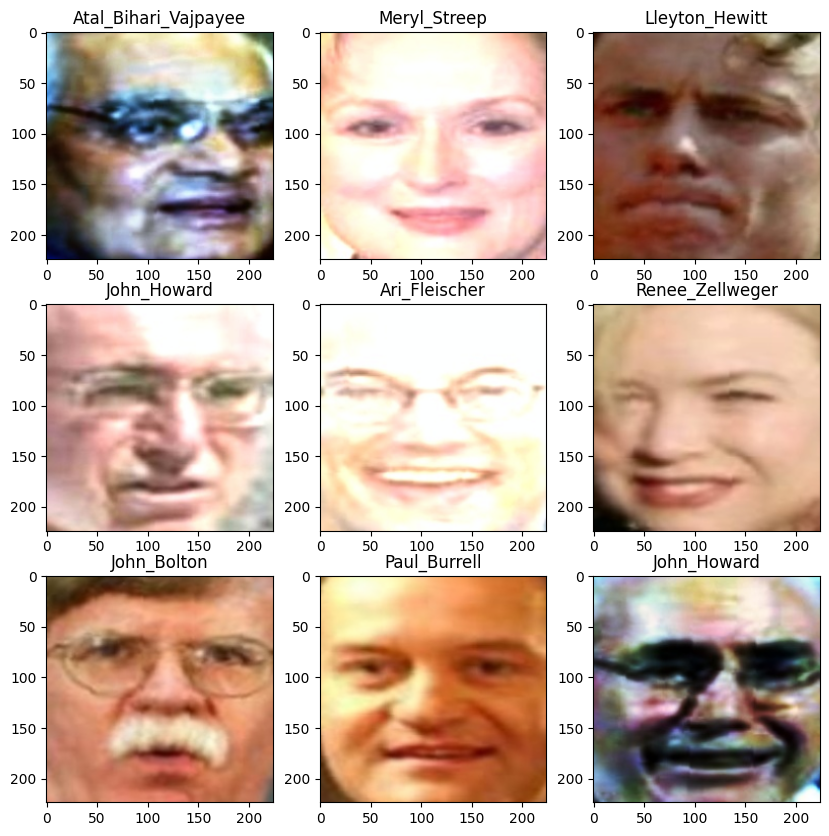

In [6]:
idx_l = [np.random.randint(len(st)) for i in range(9)]

std = [0.229, 0.224, 0.225]
mean=[0.485, 0.456, 0.406]

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i in range(len(idx_l)):
    axes[i//3, i%3].imshow(st[idx_l[i]][0].permute(1, 2, 0).numpy() * std + mean)
    axes[i//3, i%3].set_title(st.label[st[idx_l[i]][1]])

In [7]:
train_split = 0.80
val_split = 0.10
test_split = 0.10

num_samples = len(st)
num_train = int(train_split * num_samples)
num_val = int(val_split * num_samples)
num_test = num_samples - num_train - num_val

indices = list(range(num_samples))
np.random.shuffle(indices)
train_indices = indices[:num_train]
val_indices = indices[num_train:num_train + num_val]
test_indices = indices[num_train + num_val:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

batch_size = 64
train_loader = torch.utils.data.DataLoader(st, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(st, batch_size=batch_size, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(st, batch_size=batch_size, sampler=test_sampler)

***Model***

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
class HaarFeatures(nn.modules.Conv2d):
    def __init__(self, kernel_size, padding="same", stride=1, padding_mode="zeros"):
        haar_weights = self.initialise_haar_weights2d(kernel_size=kernel_size)

        in_channels = 1
        out_channels = haar_weights.shape[0]

        super(HaarFeatures, self).__init__(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=1,
            groups=1,
            bias=False,
            padding_mode=padding_mode,
        )

        with torch.no_grad():
            haar_weights = haar_weights.float().to(self.weight.device)
            self.weight.copy_(haar_weights)
            
        for i in self.parameters():
            i.requires_grad = False

    def initialise_haar_weights2d(self, kernel_size):
        if isinstance(kernel_size, list) or isinstance(kernel_size, tuple):
            assert len(kernel_size) == 2, "window size must be 2d"
        else:
            kernel_size = [kernel_size, kernel_size]

        centerdim = tuple(math.ceil(x / 2) for x in kernel_size)
        onethirddim = tuple(math.ceil(x / 3) for x in kernel_size)
        kernel_size = tuple(kernel_size)


        mean_area = torch.ones(kernel_size) / \
            (kernel_size[0] * kernel_size[1])

        full_area = torch.ones(kernel_size)

        sparse_area = torch.ones(kernel_size)
        bit_write = True
        for k0 in range(kernel_size[0]):
            for k1 in range(kernel_size[1]):
                sparse_area[k0, k1] = bit_write
                bit_write = not bit_write

            if kernel_size[1] % 2 == 0:
                bit_write = not bit_write

        if kernel_size[0] % 2 == 0:
            bit_write = not bit_write

        sparse_area = sparse_area * 2 - 1
        assert sparse_area.sum() == 0 or sparse_area.sum(
        ) == 1, "sparse area kernel not aligned"


        half_area_x = torch.ones(kernel_size)
        half_area_x[:, centerdim[1]:] = -1

        half_area_y = torch.ones(kernel_size)
        half_area_y[centerdim[0]:, :] = -1

        third_area_x = torch.ones(kernel_size)
        third_area_x[:, onethirddim[1]: 2 * onethirddim[1]] = -1

        third_area_y = torch.ones(kernel_size)
        third_area_y[onethirddim[0]: 2 * onethirddim[0], :] = -1

        quarter_area_xy = torch.ones(kernel_size)
        quarter_area_xy[: centerdim[0], centerdim[1]:] = -1
        quarter_area_xy[centerdim[0]:, : centerdim[1]] = -1

        half_quarter_area1_x = quarter_area_xy.detach().clone()
        half_quarter_area1_x[:, :centerdim[1]] = 1

        half_quarter_area2_x = quarter_area_xy.detach().clone()
        half_quarter_area2_x[:, centerdim[1]:] = 1

        half_quarter_area1_y = quarter_area_xy.detach().clone()
        half_quarter_area1_y[:centerdim[0], :] = 1

        half_quarter_area2_y = quarter_area_xy.detach().clone()
        half_quarter_area2_y[centerdim[0]:, :] = 1

        mean_area.unsqueeze_(dim=0)
        full_area.unsqueeze_(dim=0)
        sparse_area.unsqueeze_(dim=0)

        half_area_x.unsqueeze_(dim=0)
        half_area_y.unsqueeze_(dim=0)

        third_area_x.unsqueeze_(dim=0)
        third_area_y.unsqueeze_(dim=0)

        quarter_area_xy.unsqueeze_(dim=0)

        half_quarter_area1_x.unsqueeze_(dim=0)
        half_quarter_area2_x.unsqueeze_(dim=0)

        half_quarter_area1_y.unsqueeze_(dim=0)
        half_quarter_area2_y.unsqueeze_(dim=0)

        all_features = torch.cat(
            [
                mean_area,
                full_area,
                sparse_area,
                half_area_x,
                half_area_y,
                third_area_x,
                third_area_y,
                quarter_area_xy,
                half_quarter_area1_x,
                half_quarter_area2_x,
                half_quarter_area1_y,
                half_quarter_area2_y,
            ]
        )

        all_features.unsqueeze_(dim=1)

        return all_features

In [10]:
class EdgeR(nn.Module):
    def __init__(self):
        super().__init__()
        self.filter = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1, padding=1, bias=False)

        Gx = torch.tensor([[2.0, 0.0, -2.0], [4.0, 0.0, -4.0], [2.0, 0.0, -2.0]])
        Gy = torch.tensor([[2.0, 4.0, 2.0], [0.0, 0.0, 0.0], [-2.0, -4.0, -2.0]])
        G = torch.cat([Gx.unsqueeze(0), Gy.unsqueeze(0)], 0)
        G = G.unsqueeze(1)
        self.filter.weight = nn.Parameter(G, requires_grad=False)
        
        for i in self.parameters():
            i.requires_grad = False

    def forward(self, img):
        x = self.filter(img)
        x = torch.mul(x, x)
        #x = torch.sum(x, dim=1, keepdim=True)
        x = torch.sqrt(x)
        return x

In [11]:
class HybridFaceModel(nn.Module):
    def __init__(self, in_sz, kernel_sz, linear_sz):
        super(HybridFaceModel, self).__init__()
        
        self.inp_sz = in_sz
        
        # 3 x 12 channels
        self.l1hr = HaarFeatures(kernel_sz)
        self.l1hg = HaarFeatures(kernel_sz)
        self.l1hb = HaarFeatures(kernel_sz)
        
        #3 x 2 channels
        self.l1er = EdgeR()
        self.l1eg = EdgeR()
        self.l1eb = EdgeR()
        
        # total 3 x 14 = 42 channels
        
        self.l2 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        
        self.l3 = nn.Sequential(
            nn.Conv2d(in_channels=3*14, out_channels=3, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        )
        
        tmp_net = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
        tmp_net.fc = nn.Linear(tmp_net.fc.in_features, linear_sz)
        
        self.l4 = tmp_net
    
    def forward(self, X):
        """
        X -> (B, C, H, W)
        """
        x_1 = torch.cat((self.l1hr(X[:, 0, :, :].unsqueeze(1)), self.l1hg(X[:, 1, :, :].unsqueeze(1)), 
                  self.l1hb(X[:, 2, :, :].unsqueeze(1)), self.l1er(X[:, 0, :, :].unsqueeze(1)), 
                  self.l1eg(X[:, 1, :, :].unsqueeze(1)), self.l1eb(X[:, 2, :, :].unsqueeze(1))), dim=1)
        
        x_2 = self.l2(x_1)
        
        x_3 = self.l3(x_2)
        
        y = self.l4(x_3)
        
        return y
        
        
        
        

In [12]:
model = HybridFaceModel((224, 224), (3, 3), y_no)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 133MB/s]


In [13]:
model.to(device)

HybridFaceModel(
  (l1hr): HaarFeatures(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
  (l1hg): HaarFeatures(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
  (l1hb): HaarFeatures(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
  (l1er): EdgeR(
    (filter): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (l1eg): EdgeR(
    (filter): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (l1eb): EdgeR(
    (filter): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (l2): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  (l3): Sequential(
    (0): Conv2d(42, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  )
  (l4): GoogLeNet(
    (conv1): BasicConv2d(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padd

In [14]:
model(torch.cat([st[0][0].unsqueeze(0), st[1][0].unsqueeze(0)]).to(device)).shape

torch.Size([2, 50])

In [15]:
model_ = HybridFaceModel((224, 224), (3,3), y_no)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


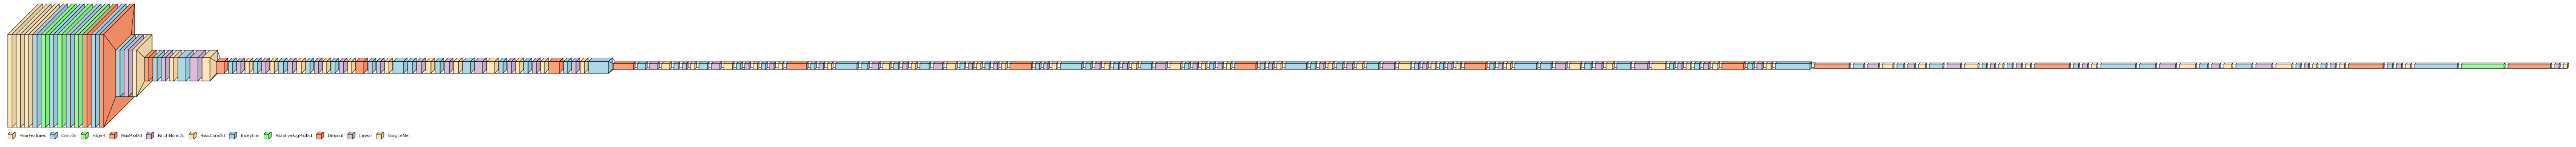

In [16]:
input_shape = (1, 3, 224, 224)

img = visualtorch.layered_view(model_, input_shape=input_shape, legend=True)
#img = cv2.resize(img, (0, 0), fx=0.25, fy=0.25) 
plt.figure(figsize=(100, 5))
plt.axis("off")
plt.imshow(img)
plt.show()

In [17]:
model_.to(device)

HybridFaceModel(
  (l1hr): HaarFeatures(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
  (l1hg): HaarFeatures(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
  (l1hb): HaarFeatures(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
  (l1er): EdgeR(
    (filter): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (l1eg): EdgeR(
    (filter): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (l1eb): EdgeR(
    (filter): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (l2): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  (l3): Sequential(
    (0): Conv2d(42, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  )
  (l4): GoogLeNet(
    (conv1): BasicConv2d(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padd

In [18]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
      HaarFeatures-1         [-1, 12, 224, 224]             108
      HaarFeatures-2         [-1, 12, 224, 224]             108
      HaarFeatures-3         [-1, 12, 224, 224]             108
            Conv2d-4          [-1, 2, 224, 224]              18
             EdgeR-5          [-1, 2, 224, 224]               0
            Conv2d-6          [-1, 2, 224, 224]              18
             EdgeR-7          [-1, 2, 224, 224]               0
            Conv2d-8          [-1, 2, 224, 224]              18
             EdgeR-9          [-1, 2, 224, 224]               0
        MaxPool2d-10         [-1, 42, 224, 224]               0
           Conv2d-11          [-1, 3, 224, 224]           1,137
        MaxPool2d-12          [-1, 3, 224, 224]               0
           Conv2d-13         [-1, 64, 112, 112]           9,408
      BatchNorm2d-14         [-1, 64, 1

***Training***

In [19]:
def train(model, linear_sz, epochs, train_loader, valid_loader, in_sz, kernel_sz, save_file, lr=0.001):
    if model is None:
        model = HybridFaceModel(in_sz, kernel_sz, linear_sz).to(device)
    
    criterion = nn.CrossEntropyLoss()
    
    opt = optim.Adam(model.parameters(), lr=lr)
    
    
    train_plot = []
    valid_plot = []
    accuracy_plot = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        for X, y in train_loader:
            opt.zero_grad()
            
            X = X.to(device)
            y = y.to(device)
            
            out = model(X)
            
            loss = criterion(out, y)
            loss.backward()
            
            opt.step()
            
            train_loss += loss.detach().cpu().item()
            
        train_loss /= len(train_loader)
        train_plot.append(train_loss)
        
        model.eval()
        valid_loss = 0
        
        for X, y in valid_loader:
            X = X.to(device)
            y = y.to(device)
            
            out = model(X)
            
            loss = criterion(out, y)
            
            valid_loss += loss.detach().cpu().item()
            
        valid_loss /= len(valid_loader)
        valid_plot.append(valid_loss)
        
        corr = 0
        total = 0
        
        for X, y in valid_loader:
            X = X.to(device)
            y = y.to(device)
            
            out = model(X)
            
            corr += (out.argmax(dim=1) == y).sum().detach().cpu().item()
            total += len(y)
            
        accuracy = corr / total * 100.0
        
        accuracy_plot.append(accuracy)
        
        print(f"Epoch {epoch}, Train loss: {train_loss}, Valid loss: {valid_loss} Accuracy: {accuracy}%")

        torch.save({
            'model': model.state_dict(),
            'train_plot': train_plot,
            'valid_plot': valid_plot,
            'accuracy_plot': accuracy_plot
            }, save_file)
    
    return model, train_plot, valid_plot, accuracy_plot
            
        
    
    

In [20]:
model, train_plot, valid_plot, accuracy_plot = train(None, y_no, 5, train_loader, val_loader, (224, 224), (7, 7), "/kaggle/working/hybrid_face_model.pth")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0, Train loss: 1.989553119554076, Valid loss: 0.47720931470394135 Accuracy: 94.41176470588235%
Epoch 1, Train loss: 0.09967598063481409, Valid loss: 0.020278781186789274 Accuracy: 100.0%
Epoch 2, Train loss: 0.008784929420365843, Valid loss: 0.0038715327391400933 Accuracy: 100.0%
Epoch 3, Train loss: 0.0038709099415343167, Valid loss: 0.0019936658597240844 Accuracy: 100.0%
Epoch 4, Train loss: 0.0024308802879437113, Valid loss: 0.001493166744088133 Accuracy: 100.0%


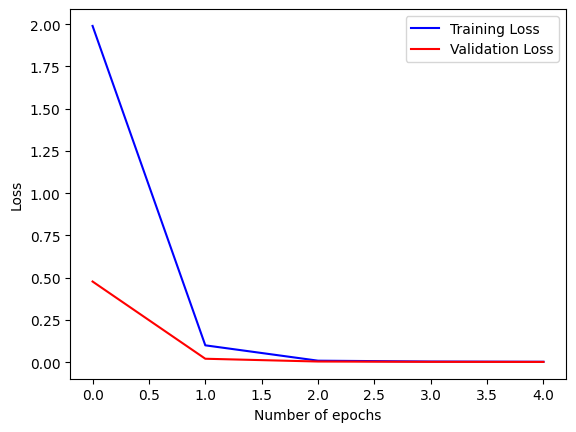

In [21]:
plt.plot(train_plot, c = 'blue', label = 'Training Loss')
plt.plot(valid_plot, c = 'red', label = 'Validation Loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

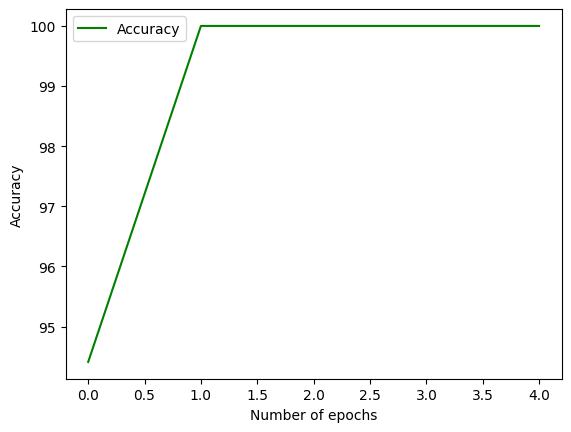

In [22]:
plt.plot(accuracy_plot, c = 'green', label = 'Accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
def test(model, test_loader, criterion):
    y_true = []
    y_pred = []
    
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred) * 100
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    return accuracy, precision, recall, f1

In [24]:
accuracy, precision, recall, f1 = test(model, test_loader, nn.CrossEntropyLoss())

In [25]:
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1_Score: {f1:.2f}")

Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1_Score: 1.00


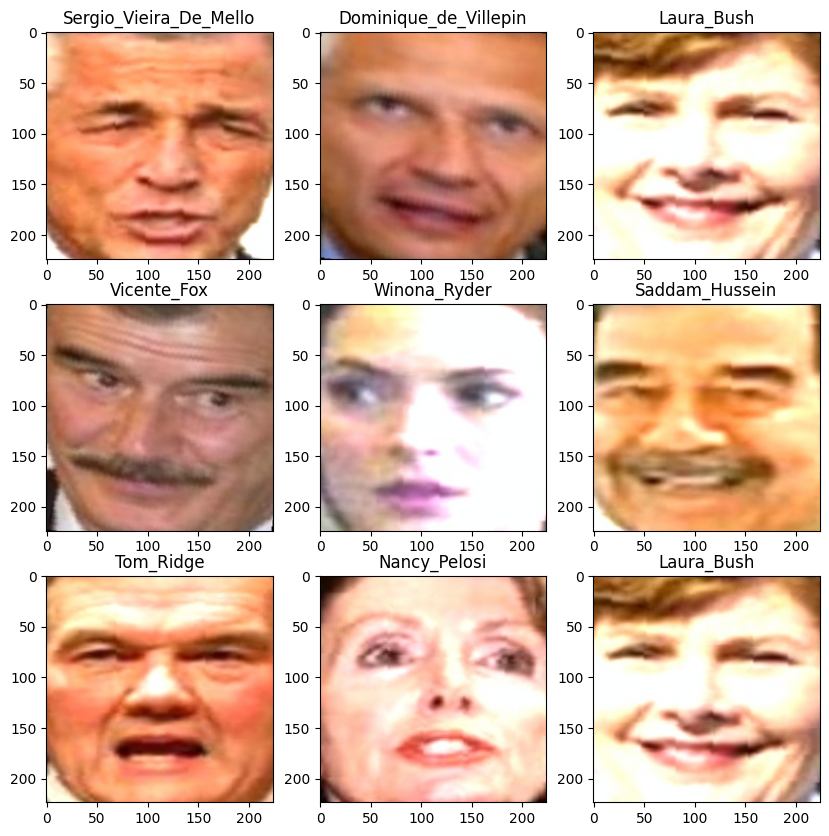

In [26]:
idx_l = [np.random.randint(len(st)) for i in range(9)]

std = [0.229, 0.224, 0.225]
mean=[0.485, 0.456, 0.406]

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i in range(len(idx_l)):
    axes[i//3, i%3].imshow(st[idx_l[i]][0].permute(1, 2, 0).numpy() * std + mean)
    axes[i//3, i%3].set_title(st.label[torch.argmax(model(st[idx_l[i]][0].unsqueeze(0).to(device)).detach()).cpu()])

***Custom Dataset***

In [27]:
ct = FaceDataset(256, 256, PATH="/kaggle/input/custom-dataset/Custom_Dataset")

In [28]:
y_no = len(ct.label)
print(y_no)

39


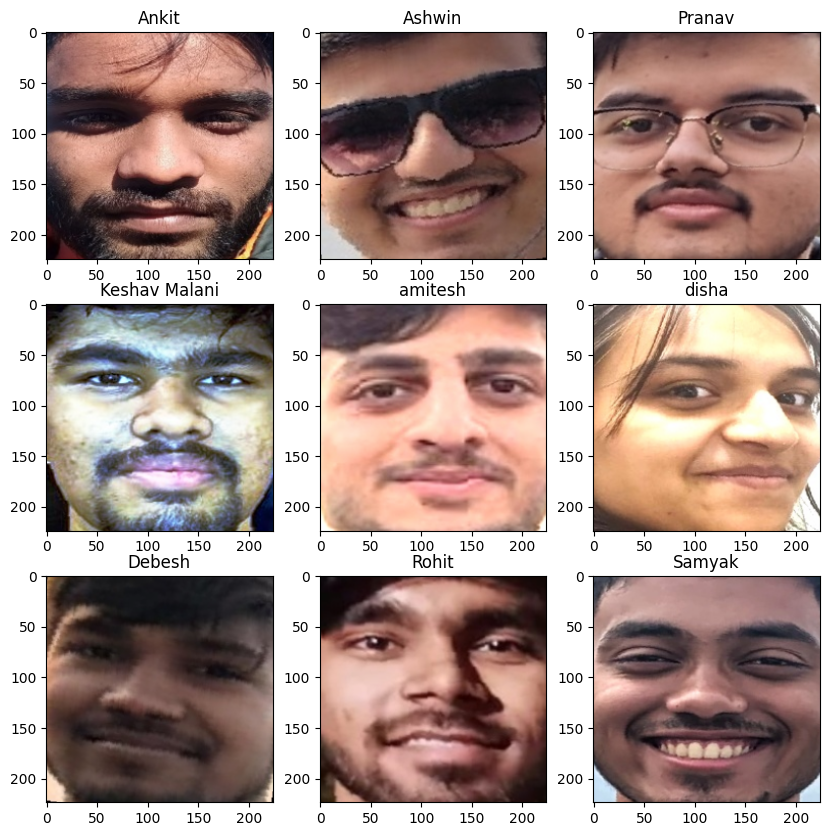

In [29]:
idx_l = [np.random.randint(len(ct)) for i in range(9)]

std = [0.229, 0.224, 0.225]
mean=[0.485, 0.456, 0.406]

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i in range(len(idx_l)):
    axes[i//3, i%3].imshow(ct[idx_l[i]][0].permute(1, 2, 0).numpy() * std + mean)
    axes[i//3, i%3].set_title(ct.label[ct[idx_l[i]][1]])

In [30]:
train_split = 0.80
val_split = 0.10
test_split = 0.10

num_samples = len(ct)
num_train = int(train_split * num_samples)
num_val = int(val_split * num_samples)
num_test = num_samples - num_train - num_val

indices = list(range(num_samples))
np.random.shuffle(indices)
train_indices = indices[:num_train]
val_indices = indices[num_train:num_train + num_val]
test_indices = indices[num_train + num_val:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

batch_size = 64
train_loader = torch.utils.data.DataLoader(ct, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(ct, batch_size=batch_size, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(ct, batch_size=batch_size, sampler=test_sampler)

In [31]:
model, train_plot, valid_plot, accuracy_plot = train(None, y_no, 3, train_loader, val_loader, (224, 224), (7, 7), "/kaggle/working/hybrid_face_model.pth")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0, Train loss: 1.7301712764634027, Valid loss: 0.41636334657669066 Accuracy: 94.66192170818505%
Epoch 1, Train loss: 0.06504272855818272, Valid loss: 0.02515157628804445 Accuracy: 100.0%
Epoch 2, Train loss: 0.008701355481106374, Valid loss: 0.0035275286063551903 Accuracy: 100.0%


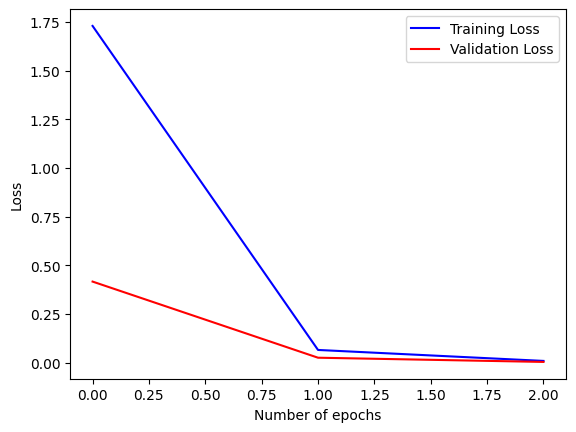

In [32]:
plt.plot(train_plot, c = 'blue', label = 'Training Loss')
plt.plot(valid_plot, c = 'red', label = 'Validation Loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

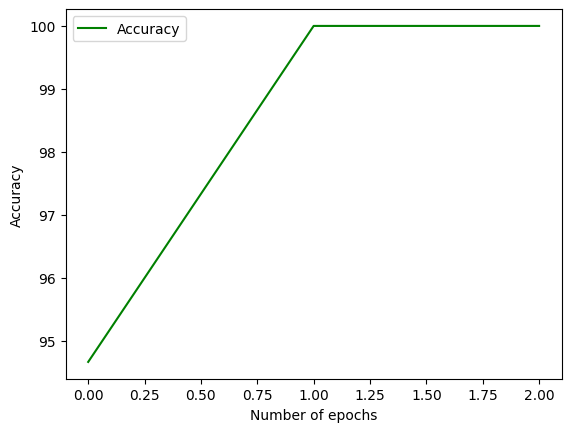

In [33]:
plt.plot(accuracy_plot, c = 'green', label = 'Accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [34]:
accuracy, precision, recall, f1 = test(model, test_loader, nn.CrossEntropyLoss())

In [35]:
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1_Score: {f1:.2f}")

Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1_Score: 1.00


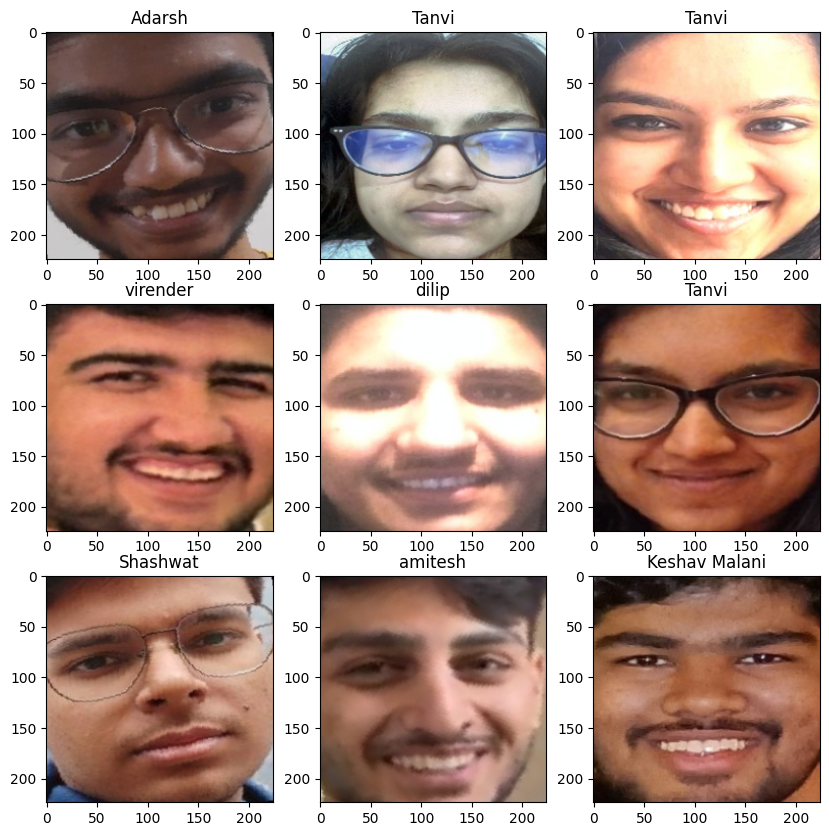

In [36]:
idx_l = [np.random.randint(len(ct)) for i in range(9)]

std = [0.229, 0.224, 0.225]
mean=[0.485, 0.456, 0.406]

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i in range(len(idx_l)):
    axes[i//3, i%3].imshow(ct[idx_l[i]][0].permute(1, 2, 0).numpy() * std + mean)
    axes[i//3, i%3].set_title(ct.label[torch.argmax(model(ct[idx_l[i]][0].unsqueeze(0).to(device)).detach()).cpu()])